## This is an algorithm development playground for UBS Quant contest

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Concatenate
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
def moving_window_normalize(df, moving_window=30, future_window=14, do_std=False):
    """
    use a moving window of size moving_window to calculate the mean and std of data,
    use these values as the estimated mean and std for next furture_window no. of days
    
    return processed df and the start index of the df 
        (data before start index is not normalized and should be pruned later)
    """
    for i in range(len(df) - future_window, moving_window-1, -future_window): 
        # the sequence is going from the end to avoid creating intemdiate data storage
        mean = df.iloc[i-moving_window:i, :].mean()
        df.iloc[i:i+future_window, :] -= mean
        
        # not sure if we should comepare the change with std
        if do_std:
            df.iloc[i:i+future_window, :] /= df.iloc[i-moving_window:i, :].std()
        else:
            df.iloc[i:i+future_window, :] /= mean
            
    # return from the frist index that is normalized
    return df, i

def get_quarter_change_rate(df):
    """
    for factor that change every quarter, the way to deal with that is to use the first order derivative directly
    """
    this_quarter = df.iloc[0, :]
    start_index = -1
    for i in range(1, len(df)):
        cur_row = df.iloc[i, :]
        if not (cur_row == this_quarter).all():
            # update start index if necessary
            if start_index == -1:
                start_index = i
            
            # update prev_quarter and this_quarter
            prev_quarter = this_quarter.copy()
            this_quarter = cur_row.copy()
            
            # update df
            df.iloc[i, :] -= prev_quarter
            df.iloc[i, :] /= prev_quarter
            
            # store new current value for copy
            new_cur_row = df.iloc[i, :].copy()
            
        elif "new_cur_row" in locals(): 
            # if no update, duplicate the most recent none zero row
            df.iloc[i, :] = new_cur_row
            
    return df, start_index

def label_process(df, decision_window=14):
    """
    process labels in another way:
    average every 2 weeks and see the growth rate
    """
    for i in range(len(df) - decision_window, decision_window-1, -decision_window):
        mean = df.iloc[i-decision_window:i, :].mean()
        df.iloc[i:i+decision_window, :] -= mean
        df.iloc[i:i+decision_window, :] /= mean
    
    return df

In [3]:
def get_update_rate(df, n=5):
    update_rate = []
    for i in range(len(df.columns)):
        counter_start = 0
        min_counter = len(df) + 1
        for j in range(n): # go for n loops to verify the update rate
            counter = 0
            start = df.iloc[counter_start, i]
            while True:
                counter += 1
                if not start == df.iloc[counter_start+counter, i]:
                    break
            counter_start = counter + counter_start
            if counter < min_counter:
                min_counter = counter
            if counter_start >= len(df):
                break
        update_rate.append(min_counter)
    return update_rate

In [4]:
def windowed_return_rate(df, window_size):
    """
    use the mean of this window_size, and previous window_size to calcualte a stablized return rate
    
    the start_index is window_size
    """
    out = df.copy()
    
    counter = 0
    for i in range(window_size, len(df)-window_size):
        prev_mean = df.iloc[i-window_size:i, :].mean()
        cur_mean = df.iloc[i:i+window_size, :].mean()
        out.iloc[counter, :] = (cur_mean - prev_mean) / prev_mean
        
        if not (out.iloc[counter, :] <= 2).all() or not (out.iloc[counter, :] > -0.8).all():
#             print(out.iloc[counter, :])
            out.iloc[counter, :] = good_row.copy()
        else:
            good_row = out.iloc[counter, :]
            
        counter += 1
    return out.iloc[:counter, :], window_size

def get_quarter_change_rate(df):
    """
    for factor that change every quarter, the way to deal with that is to use the first order derivative directly
    """
    df = df.copy()
    this_quarter = df.iloc[0, :]
    start_index = -1
    for i in range(1, len(df)):
        cur_row = df.iloc[i, :]
        if not (cur_row == this_quarter).all():
            # update start index if necessary
            if start_index == -1:
                start_index = i
            
            # update prev_quarter and this_quarter
            prev_quarter = this_quarter.copy()
            this_quarter = cur_row.copy()
            
            # update df
            df.iloc[i, :] -= prev_quarter
            df.iloc[i, :] /= prev_quarter
            
            # store new current value for copy
            new_cur_row = df.iloc[i, :].copy()

        elif "new_cur_row" in locals(): 
            # if no update, duplicate the most recent none zero row
            df.iloc[i, :] = new_cur_row
            
    for i in range(start_index, len(df)):
        if df.iloc[i, :].max() <= 1:
            start_index = i
            # make sure all unprocessed rows are pruned
            df = df.iloc[i:, :]
            break
            
    return df, start_index

In [5]:
# data generator for training and validation of stateless lstm
def generate_train_data(df1, df2, df3, label, test_split=0.2, valid_split=0.1, seq_len=365):
    # print out data information
    print(len(df1.columns), len(df2.columns), len(df3.columns), len(label.columns))
    print(len(df1), len(df2), len(df3), len(label))
    
    # get shortest data length (assuming all data start at the same time)
    data_len = min(len(df1), len(df2), len(df3), len(label))-seq_len
    test_split_len = int(data_len*(1-test_split-valid_split))
    valid_split_len = int(data_len*(1-valid_split))
    
    # create sequence
    df1 = np.array([np.array(df1.iloc[i:i+seq_len, :]) for i in range(data_len)])
    df2 = np.array([np.array(df2.iloc[i:i+seq_len, :]) for i in range(data_len)])
    df3 = np.array([np.array(df3.iloc[i:i+seq_len, :]) for i in range(data_len)])
    label = np.array([np.array(label.iloc[i+seq_len, :]) for i in range(data_len)]) # watch out for the shift here
    
    # create test split
    return {"train_df1": df1[:test_split_len], "train_df2": df2[:test_split_len], "train_df3": df3[:test_split_len], "train_label": label[:test_split_len], \
           "test_df1": df1[test_split_len:valid_split_len], "test_df2": df2[test_split_len:valid_split_len], "test_df3": df3[test_split_len:valid_split_len], "test_label": label[test_split_len:valid_split_len],
           "valid_df1": df1[valid_split_len:], "valid_df2": df2[valid_split_len:], "valid_df3": df3[valid_split_len:], "valid_label": label[valid_split_len:]
           }


In [6]:
# read the factor time data
df = pd.read_csv("Dataset_1003.csv", index_col=[0])

# seperate S&P label out
label = df.iloc[:, :4].copy()
df = df.iloc[:, 4:].copy() # preserve them as the input data

# collect col index for daily updated factors and quarterly updated factors
rate = get_update_rate(df)
slow_update_index = [i for i, r in enumerate(rate) if r > 1 and i not in [32]]
quick_update_index = [i for i, r in enumerate(rate) if r == 1]

# seperate slowly updated factor and quickly updated factor
slow_factor_df = df.iloc[:, slow_update_index]
quick_factor_df = df.iloc[:, quick_update_index]

# process label
label, label_start_index = windowed_return_rate(label, window_size=14)

# process fast updated factor
quick_factor_df, quick_start_index = windowed_return_rate(quick_factor_df, window_size=14)

# process slowly updated factor
slow_factor_df, slow_start_index = get_quarter_change_rate(slow_factor_df)

# determine which row the start with
start_index = max(slow_start_index, quick_start_index, label_start_index)

# remove the rows before start_index
label = label.iloc[start_index-label_start_index:, :]
quick_factor_df = quick_factor_df.iloc[start_index-quick_start_index:, :]
slow_factor_df = slow_factor_df.iloc[start_index-slow_start_index:, :]

In [10]:
label.abs().mean()

Open     0.022484
High     0.021468
Low      0.023483
Close    0.022465
dtype: float64

In [ ]:
# generate data
seq_len = 100
train_data = generate_train_data(slow_factor_df, quick_factor_df, label, label, seq_len=seq_len, test_split=0.2, valid_split=0.1)
try_normalization = False

# flow for prev_label_input
prev_label_input = Input(shape=(seq_len, 4))
x = Dense(units=2, activation="relu")(prev_label_input)
if try_normalization:
    x = BatchNormalization()(x)
x = LSTM(units=16, dropout=0.2, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=True)(x)
if try_normalization:
    x = BatchNormalization(axis=1)(x)
prev_label = x

# define three inputs
slow_feature_input = Input(shape=(seq_len, 25))
quick_feature_input = Input(shape=(seq_len, 19))

# flow for slow_feature_input
x = Dense(units=128, activation="relu")(slow_feature_input)
if try_normalization:
    x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(units=128, dropout=0.2, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=True)(x)
if try_normalization:
    x = BatchNormalization()(x)
slow_feature = x

# flow for quick_feature_input
x = Dense(units=128, activation="relu")(quick_feature_input)
if try_normalization:
    x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(units=128, dropout=0.2, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=True)(x)
if try_normalization:
    x = BatchNormalization()(x)
quick_feature = x

# concatenate all features
x = Concatenate(axis=-1)([slow_feature, quick_feature, prev_label])
# x = Concatenate(axis=-1)([slow_feature, quick_feature])
if try_normalization:
    x = BatchNormalization()(x)
concate_feature = x

# Further process the output
x = LSTM(units=128, dropout=0.2, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=False)(concate_feature)
if try_normalization:
    x = BatchNormalization()(x)
final_feature = x

# Final prediction
x = Dense(units=256, activation="sigmoid")(x)
if try_normalization:
    x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(units=4, activation="sigmoid")(x)

# compile model
Indexer = Model(inputs=[slow_feature_input, quick_feature_input, prev_label_input], outputs=[output])
Indexer.compile(loss="mse", optimizer='adam', metrics=['mse'])

# display model
plot_model(model=Indexer, to_file="temp.png")
Indexer.summary()

25 19 4 4
4465 4451 4451 4451
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 200, 25)      0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 200, 19)      0                                            
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 200, 128)     3328        input_39[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 200, 128)     2560        input_40[0][0]                   
_______________________________________________________________________________

In [ ]:
Indexer.fit([train_data['train_df1'], train_data['train_df2'], train_data['train_df3']], 
             train_data['train_label'], epochs=300, batch_size=512, shuffle=True,
             verbose=1, 
             validation_data=[[train_data['test_df1'], train_data['test_df2'], train_data['test_df3']], train_data['test_label']],
             callbacks=[TensorBoard(), EarlyStopping(patience=10, min_delta=0.00001)])

scores = desc_conv_model.evaluate(x=[train_data['test_df1'], train_data['test_df2'], train_data['test_df3']], 
                                  y=[train_data['test_label']])

Train on 2975 samples, validate on 850 samples
Epoch 1/300
2975/2975 [==============================] - 20s 7ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/300
2975/2975 [==============================] - 17s 6ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/300
2975/2975 [==============================] - 18s 6ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/300
2560/2975 [========================>.....] - ETA: 2s - loss: nan - mean_squared_error: nan

KeyboardInterrupt: 

### Currently the system is overfitting to the average
### The following methods are to be attempted
1. Try to remove corelated input features
2. Simplify the current network in a proper way

In [141]:
which = "valid"
predicted = Indexer.predict_on_batch([train_data[which+'_df1'], train_data[which+'_df2'], train_data[which+'_df3']])
predicted = predicted.mean(axis=1)
label = train_data[which+"_label"].mean(axis=1)

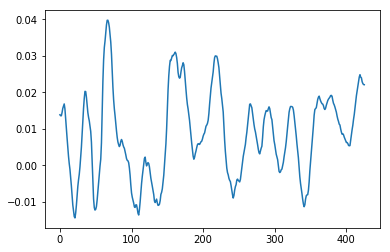

In [142]:
x = np.arange(0, label.shape[0])
y1 = predicted
y2 = label
plt.plot(x, y2)

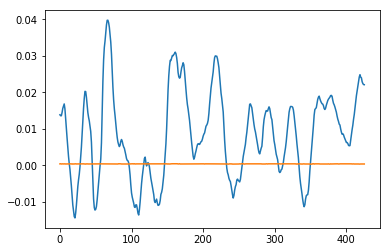

In [143]:
plt.plot(x, y2)
plt.plot(x, y1)